In [1]:
import os
import cv2
import random
import time 

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_hub as tfhub
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Sequential,models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import ReduceLROnPlateau


from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')

2024-03-30 11:29:34.222212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 11:29:34.222316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 11:29:34.343646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%matplotlib inline

In [3]:

BATCH = 32

In [4]:
len(os.listdir('/kaggle/input/brain-tumor-mri-images-44c/'))

44

In [5]:
data_path= "/kaggle/input/brain-tumor-mri-images-44c"

In [6]:
df = pd.DataFrame(columns=['path','label'])

In [7]:
#df.to_pickle('actual_df.pkl')


In [8]:
#df = create_df(df,folder,data_path)
#df.head()

In [9]:
folder = os.listdir(data_path)
def create_df(df,folder,data_path):
    for fold in folder:
        class_path = os.path.join(data_path,fold)
        class_folder = os.listdir(class_path)
        for img in class_folder:
            img_path = os.path.join(class_path,img)
            df = df._append({'path':os.path.join(class_path,img) , 'label' : fold.split()[1]},ignore_index=True)
    return df

In [10]:
#df.to_pickle('three_classed.pkl')


In [11]:
df = pd.read_pickle('/kaggle/input/tumor-df/initial_dataset.pkl')
df.head()

,path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2


In [12]:
df.shape

(4479, 2)

In [13]:
label_counts = df['label'].value_counts().sort_values(ascending=False)
sorted_label = label_counts.index

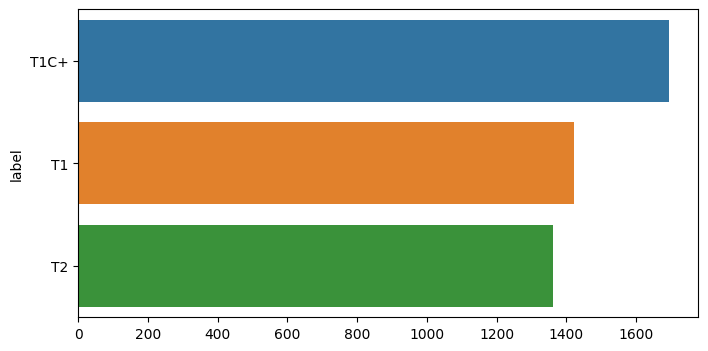

In [14]:
plt.figure(figsize=(8,4))
sns.barplot(x=label_counts.values, y=sorted_label)
plt.show()

In [15]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

In [16]:
df_shuffle = df.sample(frac=1).reset_index(drop=True)
df_shuffle.head()

,path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Astro...,T1
1,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1
2,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,T1
3,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,T2
4,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1C+


In [17]:
train_df, tv_df = train_test_split(df,test_size= 0.35,shuffle=True,random_state=101,stratify= df['label'])
test_df, valid_df = train_test_split(tv_df,test_size= 0.5,shuffle=True,random_state=101,
                                          stratify= tv_df['label'])

In [18]:
train_df

,path,label
1382,/kaggle/input/brain-tumor-mri-images-44c/Astro...,T2
76,/kaggle/input/brain-tumor-mri-images-44c/Tuber...,T1C+
2201,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1
2516,/kaggle/input/brain-tumor-mri-images-44c/Epend...,T1C+
2694,/kaggle/input/brain-tumor-mri-images-44c/Epend...,T1
...,...,...
905,/kaggle/input/brain-tumor-mri-images-44c/Carci...,T1
2039,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,T1C+
2688,/kaggle/input/brain-tumor-mri-images-44c/Medul...,T1
4195,/kaggle/input/brain-tumor-mri-images-44c/Gliob...,T1


In [19]:
train_label_counts = train_df['label'].value_counts().sort_values(ascending=False)
train_sorted_label = train_label_counts.index

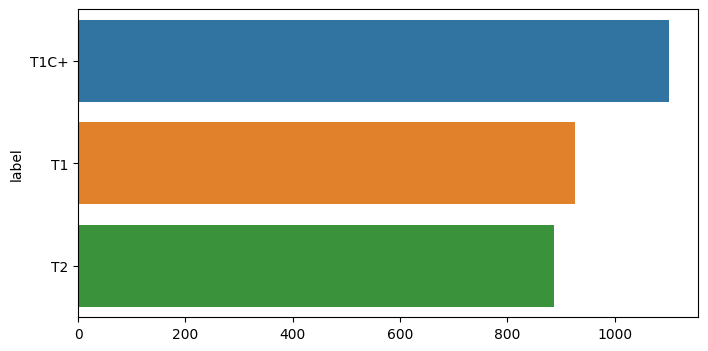

In [20]:
plt.figure(figsize=(8,4))
sns.barplot(x=train_label_counts.values, y=train_sorted_label)
plt.show()

In [21]:
test_df


,path,label
507,/kaggle/input/brain-tumor-mri-images-44c/Gangl...,T2
2164,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,T1C+
2357,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1
1107,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T2
27,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
...,...,...
1398,/kaggle/input/brain-tumor-mri-images-44c/Astro...,T2
2391,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1
2480,/kaggle/input/brain-tumor-mri-images-44c/Granu...,T1C+
1996,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,T1C+


In [22]:
test_label_counts = test_df['label'].value_counts().sort_values(ascending=False)
test_sorted_label = test_label_counts.index

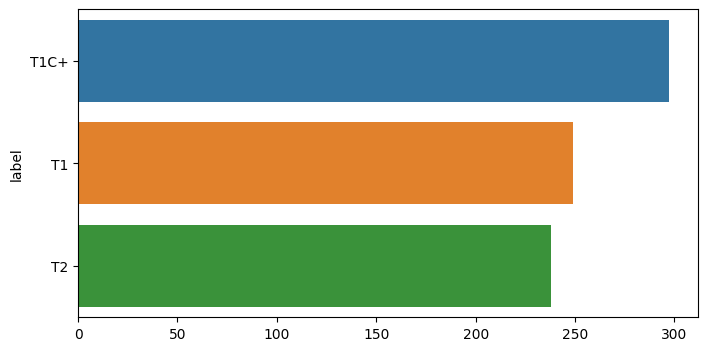

In [23]:
plt.figure(figsize=(8,4))
sns.barplot(x=test_label_counts.values, y=test_sorted_label)
plt.show()

In [24]:
valid_df

,path,label
2239,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1
3546,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T1C+
3883,/kaggle/input/brain-tumor-mri-images-44c/Medul...,T1C+
3659,/kaggle/input/brain-tumor-mri-images-44c/Oligo...,T2
2640,/kaggle/input/brain-tumor-mri-images-44c/Carci...,T1C+
...,...,...
2094,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,T1C+
2909,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1C+
2651,/kaggle/input/brain-tumor-mri-images-44c/Carci...,T1C+
79,/kaggle/input/brain-tumor-mri-images-44c/Tuber...,T1C+


In [25]:
valid_label_counts = valid_df['label'].value_counts().sort_values(ascending=False)
valid_sorted_label = valid_label_counts.index

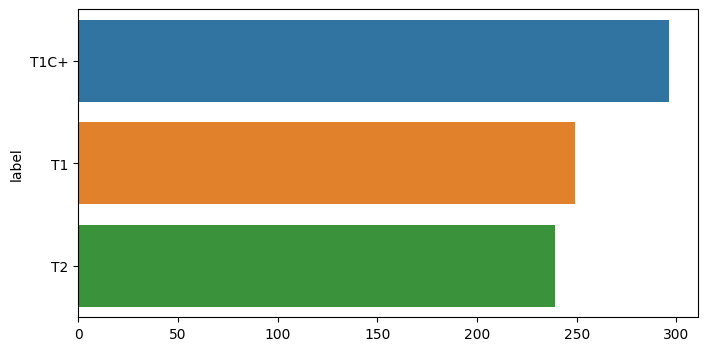

In [26]:
plt.figure(figsize=(8,4))
sns.barplot(x=valid_label_counts.values, y=valid_sorted_label)
plt.show()

In [27]:
img_size = (229,229)

In [28]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=img_size,  # Resize images to 150x150
    color_mode='rgb',
    class_mode="categorical",  
    batch_size=BATCH,
    shuffle=True
)

Found 2910 validated image filenames belonging to 3 classes.


In [29]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='label',
    target_size=img_size,  # Resize images to 150x150
    color_mode='rgb',
    class_mode="categorical",  # "raw" for regression tasks, "binary" for binary classification
    batch_size=BATCH,
    shuffle=True
)

Found 784 validated image filenames belonging to 3 classes.


In [30]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=img_size,  # Resize images to 150x150
    color_mode='rgb',
    class_mode="categorical",  # "raw" for regression tasks, "binary" for binary classification
    batch_size=BATCH,
    shuffle=True
)

Found 784 validated image filenames belonging to 3 classes.


In [31]:

xcept = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='max'
)

83683744/83683744 [==============================] - 5s 0us/step


In [32]:
xcept

In [33]:

class TumorClassifierModel:
    def __init__(self, inputs):
        self.inputs = inputs
        self.feature_extractor = self.build_feature_extractor(inputs)
        self.classifier_adaptor = self.build_classifier_adaptor(self.feature_extractor)
        self.classifier_head = self.build_classifier_head(self.classifier_adaptor)
        
    def build_feature_extractor(self, inputs):
        x = xcept(inputs)
        # Freeze the layers of the EfficientNet model
        for layer in xcept.layers:
            layer.trainable = False
    
        return x
    def build_classifier_adaptor(self, inputs):
        x = layers.Flatten()(inputs)
        x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), 
                          activation='relu')(x)
        x = layers.Dropout(rate=0.3)(x)
        return x

    def build_classifier_head(self, inputs):
        x = layers.Dense(3, activation='softmax')(inputs)
        return x

    def build_model(self):
        model = tf.keras.Model(inputs=self.inputs, outputs=self.classifier_head)
        return model



In [34]:

inputs = tf.keras.Input(shape=(299, 299, 3)) 





In [35]:
tumor_classifier = TumorClassifierModel(inputs)


In [36]:
model = tumor_classifier.build_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21386795 (81.58 MB)
Trainable params: 525315 (2

In [37]:
model.optimizer.get_config() 

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 0.001,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 10,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.001,
)

In [39]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.h8', 
                             monitor='val_loss',
                             verbose = 1,
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min'
                             )

In [40]:


from sklearn.utils.class_weight import compute_class_weight


In [41]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [42]:
history = model.fit(x= train_generator,
                    steps_per_epoch = 20,
                    epochs= 100, 
                    callbacks=[early_stopping, model_checkpoint,reduce_lr],
                    validation_data= valid_generator)

Epoch 1/100


I0000 00:00:1711798213.193522      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 [==============================] - ETA: 0s - loss: 2.1074 - accuracy: 0.5361
Epoch 1: val_loss improved from inf to 1.51695, saving model to model_weights.h8
20/20 [==============================] - 33s 1s/step - loss: 2.1074 - accuracy: 0.5361 - val_loss: 1.5169 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.1345 - accuracy: 0.6922
Epoch 2: val_loss improved from 1.51695 to 0.94122, saving model to model_weights.h8
20/20 [==============================] - 21s 1s/step - loss: 1.1345 - accuracy: 0.6922 - val_loss: 0.9412 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.8855 - accuracy: 0.7984
Epoch 3: val_loss improved from 0.94122 to 0.77840, saving model to model_weights.h8
20/20 [==============================] - 21s 1s/step - loss: 0.8855 - accuracy: 0.7984 - val_loss: 0.7784 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 4/100
20/20 [==============================]

In [43]:
train_score= model.evaluate(train_generator)
valid_score= model.evaluate(valid_generator)
test_score=  model.evaluate(test_generator)

25/25 [==============================] - 14s 542ms/step - loss: 0.3195 - accuracy: 0.9324


In [44]:
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('=' * 20)
print( )
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('=' * 20)
print( )
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

Train Loss:  0.31151312589645386
Train Accuracy:  0.929896891117096

Valid Loss:  0.3065538704395294
Valid Accuracy:  0.9400510191917419

Test Loss:  0.31953126192092896
Test Accuracy:  0.9323979616165161


In [45]:
#model.save('/kaggle/working/xception_model')

In [46]:
'''
import zipfile

base_dir = '/kaggle/working'

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(path, '..')))

with zipfile.ZipFile(os.path.join(base_dir, 'augmented_images.zip'), 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('augmented_images/', zipf)

for pkl_file in ['augmented_balanced_dataset.pkl', 'initial_dataset.pkl']:
    with zipfile.ZipFile(os.path.join(base_dir, f"{pkl_file}.zip"), 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(os.path.join(base_dir, pkl_file), pkl_file)

print('Created separate ZIP files for each item.')
'''


'\nimport zipfile\n\nbase_dir = \'/kaggle/working\'\n\ndef zipdir(path, ziph):\n    for root, dirs, files in os.walk(path):\n        for file in files:\n            ziph.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(path, \'..\')))\n\nwith zipfile.ZipFile(os.path.join(base_dir, \'augmented_images.zip\'), \'w\', zipfile.ZIP_DEFLATED) as zipf:\n    zipdir(\'augmented_images/\', zipf)\n\nfor pkl_file in [\'augmented_balanced_dataset.pkl\', \'initial_dataset.pkl\']:\n    with zipfile.ZipFile(os.path.join(base_dir, f"{pkl_file}.zip"), \'w\', zipfile.ZIP_DEFLATED) as zipf:\n        zipf.write(os.path.join(base_dir, pkl_file), pkl_file)\n\nprint(\'Created separate ZIP files for each item.\')\n'